In [1]:
from __future__ import division


import numpy as np
import pandas as pd


import itertools
import math

import matplotlib.pyplot as plt
from random import randint
from matplotlib import style
import seaborn as sns

In [2]:
import acquire_log as aq

In [3]:
df = aq.get_log_data()

In [4]:
df.head()

,ip,timestamp,req,status,size,dash3,usr_agnt
0,97.105.19.58,2019-04-16 19:34:42,"""GET/api/v1/sales?page=81HTTP/1.1""",200,512495,"""-""","""python-requests/2.21.0"""
1,97.105.19.58,2019-04-16 19:34:42,"""GET/api/v1/itemsHTTP/1.1""",200,3561,"""-""","""python-requests/2.21.0"""
2,97.105.19.58,2019-04-16 19:34:44,"""GET/api/v1/sales?page=82HTTP/1.1""",200,510103,"""-""","""python-requests/2.21.0"""
3,97.105.19.58,2019-04-16 19:34:46,"""GET/api/v1/sales?page=83HTTP/1.1""",200,510003,"""-""","""python-requests/2.21.0"""
4,97.105.19.58,2019-04-16 19:34:48,"""GET/api/v1/sales?page=84HTTP/1.1""",200,511963,"""-""","""python-requests/2.21.0"""


In [5]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [6]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [8]:
df.head(1)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


In [9]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [10]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [11]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [12]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 7 columns):
ip                13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
size_mb           13978 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 873.6+ KB


In [14]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1items HTTP/1.1                           2
GET /api/v1 HTTP/1.1                                1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1/helloclass! HTTP

In [15]:
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [16]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
52.87.230.102         2
35.175.171.137        2
70.121.214.34         2
34.229.70.250         1
54.145.52.184         1
52.90.165.200         1
95.31.16.121          1
3.92.201.136          1
45.23.250.16          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
97.105.15.120         1
52.91.30.150          1
95.31.18.119          1
35.174.209.2          1
Name: ip, dtype: int64

In [17]:
df.request_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

## Detecting anomalies in already existing data by proportion: (using request agent)

In [22]:
ra_df = pd.DataFrame(df['request_agent'].value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_count'})
ra_df2 = pd.DataFrame(df['request_agent'].value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})
ra_df = ra_df.merge(ra_df2)

In [24]:
ra_df

,request_agent,agent_count,agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [27]:
ra_df[ra_df.agent_proba < .01]

,request_agent,agent_count,agent_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [33]:
print('Number of request agents: {}'.format(len(ra_df)))

print(ra_df.tail(7))

Number of request agents: 9
                                       request_agent  agent_count  agent_proba
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...           34     0.002432
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...            8     0.000572
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...            7     0.000501
5       Slackbot 1.0 (+https://api.slack.com/robots)            6     0.000429
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            4     0.000286
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            2     0.000143
8                                  Python-urllib/3.7            1     0.000072


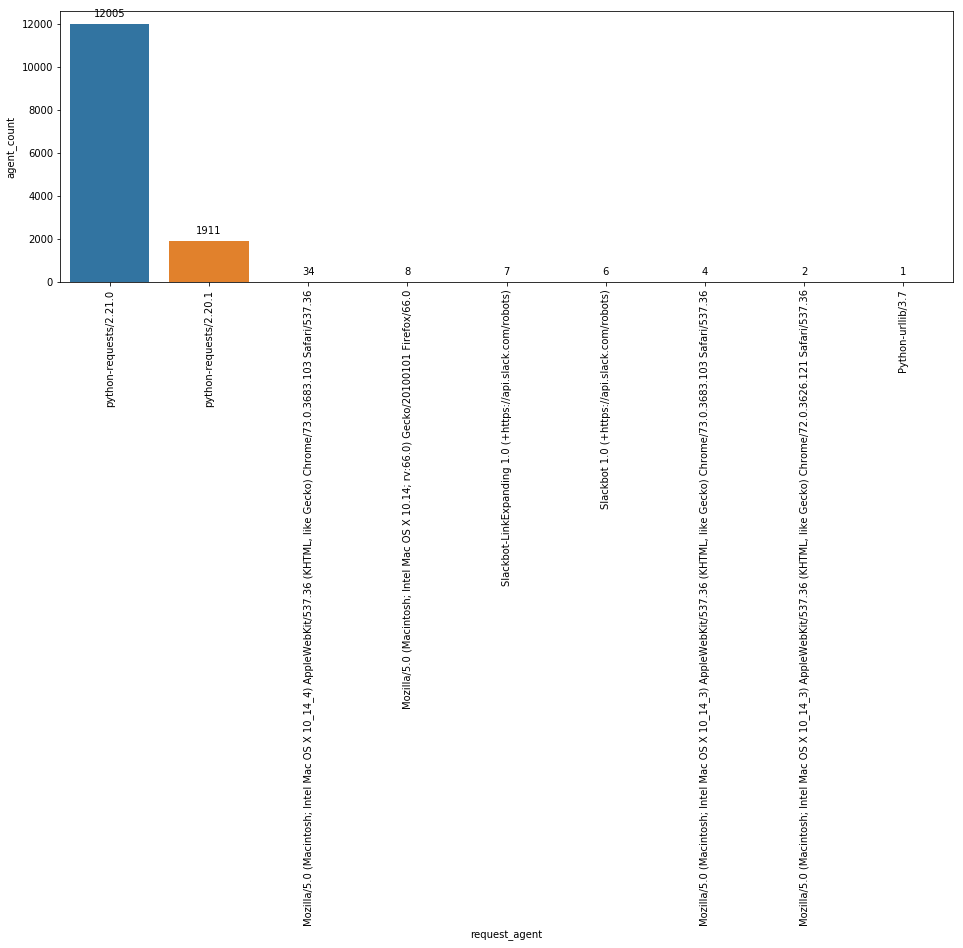

In [34]:
plt.figure(figsize=(16, 5))
splot = sns.barplot(data=ra_df, x = 'request_agent', y = 'agent_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives (using request agent)

In [48]:
train = df['2019-04-16 19:34:42':'2019-04-16 21:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [49]:
train.head(2)

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396


In [50]:
ra_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [51]:
ra_df

,request_agent,agent_proba
0,python-requests/2.21.0,0.805716
1,python-requests/2.20.1,0.190301
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002589
3,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000597
4,Slackbot 1.0 (+https://api.slack.com/robots),0.000498
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000199
6,Python-urllib/3.7,0.000100


In [52]:
df = df.reset_index().merge(ra_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.agent_proba.value_counts()

0.805716    12005
0.190301     1911
0.002589       34
0.000000       10
0.000597        7
0.000498        6
0.000199        4
0.000100        1
Name: agent_proba, dtype: int64

## Conditional Probabilities: probabilities using 2 discrete variables (request agent, ip)


In [54]:
ra_probs = train.groupby('request_agent').size().div(len(df))


In [67]:
ra_probs

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.000143
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.001860
Python-urllib/3.7                                                                                                            0.000072
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                 0.000358
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000429
python-requests/2.20.1                                                                                                       0.136715
python-requests/2.21.0                                                                                                       0.578838
dtype: float64

In [68]:
ip_given_agent = pd.DataFrame(train.groupby(['request_agent', 'ip']).\
                               size().div(len(train)).\
                               div(ra_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_ip_given_agent'})
                              )

In [69]:
ip_given_agent

,request_agent,ip,proba_ip_given_agent
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,97.105.19.58,1.391954
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,97.105.19.58,1.391954
2,Python-urllib/3.7,97.105.19.58,1.391954
3,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,0.278391
4,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,0.278391
5,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,0.278391
6,Slackbot 1.0 (+https://api.slack.com/robots),52.90.165.200,0.278391
7,Slackbot 1.0 (+https://api.slack.com/robots),54.145.52.184,0.278391
8,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.88.129.158,0.231992
9,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.92.201.136,0.231992


In [61]:
agent_ip_count = pd.DataFrame(train.groupby(['request_agent', 'ip'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_ip_count'}))

agent_status = ip_given_agent.merge(agent_ip_count)


In [62]:
agent_ip_count

,request_agent,ip,agent_ip_count
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,97.105.19.58,2
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,97.105.19.58,26
2,Python-urllib/3.7,97.105.19.58,1
3,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,1
4,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,1
5,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,1
6,Slackbot 1.0 (+https://api.slack.com/robots),52.90.165.200,1
7,Slackbot 1.0 (+https://api.slack.com/robots),54.145.52.184,1
8,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.88.129.158,1
9,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.92.201.136,1


In [64]:
df = df.reset_index().merge(agent_status, on=['request_agent', 'ip'], how='left').fillna(value=0).set_index('timestamp')

In [65]:
df

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_ip_given_agent,agent_ip_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.805716,1.391954,8091.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.805716,1.391954,8091.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.805716,1.391954,8091.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.805716,1.391954,8091.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.805716,1.391954,8091.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.805716,1.391954,8091.0
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,0,python-requests/2.21.0,0.487092,0.805716,1.391954,8091.0
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,0,python-requests/2.21.0,0.486706,0.805716,1.391954,8091.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,0,python-requests/2.21.0,0.000040,0.805716,1.391954,8091.0


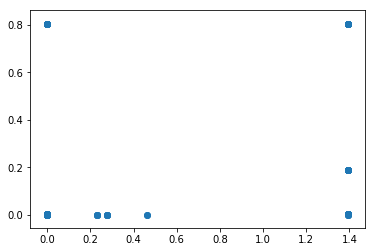

In [66]:
plt.scatter(df.proba_ip_given_agent, df.agent_proba)